<a href="https://colab.research.google.com/github/Fortuz/acdc_sr/blob/main/draw_recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# szukseges importok
from google.colab import drive
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
import json
import math
import ast
import random
import cv2
import tensorflow as tf
from PIL import Image
from tensorflow.keras.layers import LSTM, Dense, Layer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

In [ ]:
# kaggle csatlakozas, dataset letoltese drivera
# csak elso futattasnal szukseges
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
%cd /content/drive/My\ Drive/Draw_Recognition
!pip install --upgrade --force-reinstall --no-deps kaggle
! kaggle competitions download -c quickdraw-doodle-recognition
drive.mount('/content/drive')
! unzip quickdraw-doodle-recognition.zip

In [2]:
# csatlakozas a drivera
drive.mount('/content/drive')
# globalis valtozok
train_amount = 10000
test_amount = 1000
directory_path = '/content/drive/MyDrive/Draw_Recognition/train_simplified/'
preproccessed_train_directory_path = '/content/drive/MyDrive/Draw_Recognition/preproccessed_train_data'
preproccessed_test_directory_path = '/content/drive/MyDrive/Draw_Recognition/preproccessed_test_data'
models_directory_path = '/content/drive/MyDrive/Draw_Recognition/models/'
categories_path = '/content/drive/MyDrive/Draw_Recognition/categories.json'
max_length = 300  # ilyen hosszura fogjuk kitolni a pontsorozatokat
num_classes = 20 # kategoriak szama
model_ckpt = 'lstm_attention_model_weights.h5'
cnn_model_ckpt = 'cnn_model_weights.keras'

Mounted at /content/drive


In [3]:
# fuggveny, ami beolvas egy csv-t es feldolgozza
def read_format_csv(csv_name, word_id):
  csv = pd.read_csv(csv_name) # beolvasas
  csv = csv.drop('timestamp', axis=1) # felesleges oszlop
  csv = csv.drop('countrycode', axis=1) # felesleges oszlop
  csv = csv.drop('key_id', axis=1) # felesleges oszlop
  csv = csv[csv['recognized'] == True] # csak azokat tartsuk meg, amelyek felismerhetoen vannak rajzolva
  csv = csv.drop('recognized',axis =1) # felesleges oszlop
  csv['word_id'] = word_id # szo azonosito hozzadas
  csv = csv.sample(frac=1) # megkeveres
  return csv.head(train_amount+test_amount) # elso X sor megtartasa

In [ ]:
# feldolgozza a datasetet es elmenti, hogy milyen aranyban felismert a rajz
# csak elso futtatasnal
rates = [] # aranyok
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')] # fajlok nevei
for csv_file in tqdm(csv_files):
  csv = pd.read_csv(os.path.join(directory_path, csv_file)) # fajl beolvasasa
  rate = len(csv[csv['recognized'] == True]) / len(csv) # arany meghatarozasa
  rates.append((csv_file, rate)) # (fajl neve, felismert arany) tuple hozzaadas a listahoz

100%|██████████| 340/340 [10:11<00:00,  1.80s/it]


In [ ]:
# uj kategoriak meghatarozasa az aranyok alapjan
# csak elso futtatasnal
exclude = ['grass.csv','zigzag.csv','line.csv','triangle.csv','vase.csv','cloud.csv','rain.csv']
rates = [item for item in rates if item[0] not in exclude]
categories = sorted(rates, key=lambda x: x[1], reverse=True)[0:num_classes]

In [ ]:
# elmentjuk az uj kategoriak csv file-jat feldolgozva es zippelve
# csak elso futtatasnal
test_dataframe = pd.DataFrame() # pandas dataframe
for i,cat in tqdm(enumerate(categories)):
  csv = read_format_csv(os.path.join(directory_path, cat[0]), i) # beolvassuk az uj kategoria szerinti csv-t
  csv.head(train_amount).to_csv(os.path.join(preproccessed_train_directory_path,f'train_{cat[0]}.gz'), index=False, compression='gzip') # az elso train_amount sort tartjuk meg es kiirjuk
  test_dataframe = pd.concat([test_dataframe,csv[train_amount: train_amount + test_amount]]) # a teszt adatokat kigyujtjuk
test_dataframe.sample(frac=1).to_csv(os.path.join(preproccessed_test_directory_path, 'test_data.gz'), index=False, compression='gzip') # teszt adatokat megkeverjuk es kiirjuk

20it [00:51,  2.56s/it]


In [4]:
# beolvassuk a mar elore feldolgozott adatokat es megkeverjuk
dataframe = pd.DataFrame()
csv_files = [file for file in os.listdir(preproccessed_train_directory_path) if file.endswith('.gz')]
for csv_file in tqdm(csv_files):
  csv = pd.read_csv(os.path.join(preproccessed_train_directory_path, csv_file), compression='gzip')
  dataframe = pd.concat([dataframe, csv])

for i in range(0,5):
  dataframe = dataframe.sample(frac=1).reset_index(drop=True)

100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


In [10]:
# kategoriak neveinek kiirasa jsonbe
# csak elso futattasnal
unique_combinations_dict = dataframe[['word', 'word_id']].drop_duplicates().to_dict(orient='records')
json_output_combinations = json.dumps(unique_combinations_dict, ensure_ascii=False)
with open(categories_path, 'w', encoding='utf-8') as file:
    file.write(json_output_combinations)

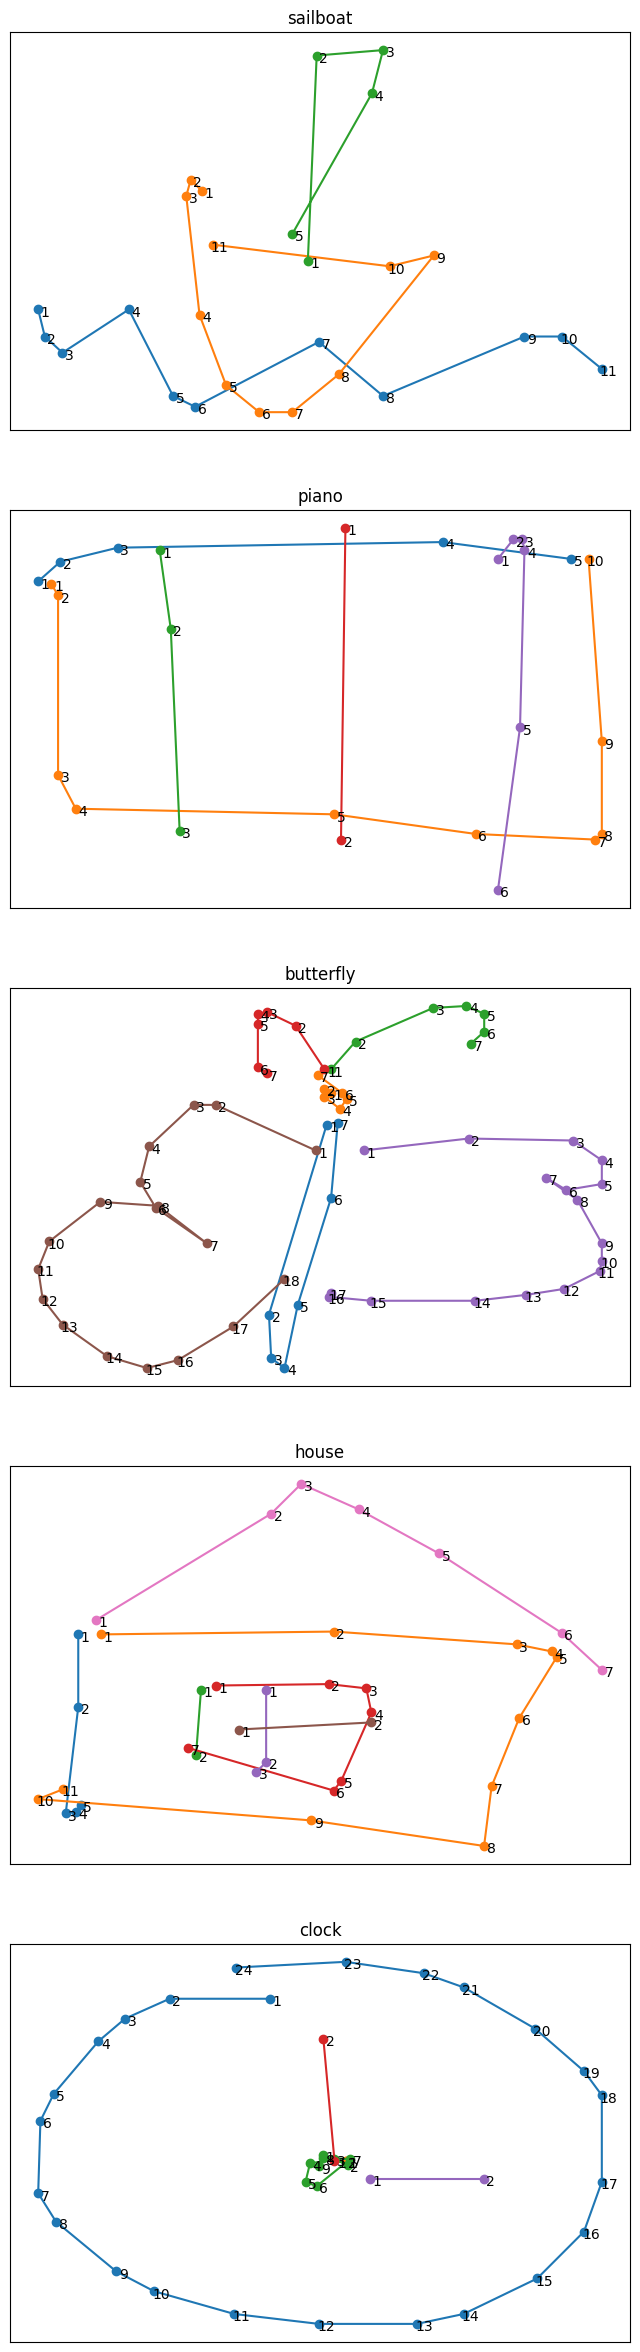

In [ ]:
# nehany abra kirajzolasa
test_data = dataframe
fig, axs = plt.subplots(5, 1, figsize=(8, 30))
for drawing_ind in range(0,5):
  for i, (x, y) in enumerate(json.loads(test_data['drawing'][drawing_ind])):
      axs[drawing_ind].plot(x, y, marker='o')
      for j, (x_coord, y_coord) in enumerate(zip(x, y)):
          axs[drawing_ind].annotate(str(j+1), (x_coord, y_coord), textcoords="offset points", xytext=(5,-5), ha='center')
  axs[drawing_ind].invert_yaxis()
  axs[drawing_ind].set_title(test_data['word'][drawing_ind])
  axs[drawing_ind].set_xticks([])
  axs[drawing_ind].set_yticks([])
plt.show()

In [5]:
# [(x,y,1)] listat csinalunk a sorra
def process_points(row):
    # A pontsorozatok átalakítása a string formátumból listává
    points = ast.literal_eval(row)
    # Többdimenziós listából (x, y, 1) pontokká alakítás
    combined_points = []
    for segment in points:
        x = segment[0]
        y = segment[1]
        z = [1 for i in range(len(x))]
        combined_points.extend(list(zip(x, y,z)))
    return combined_points

In [6]:
# minden sorra meghatarozzuk az [(x,y,1)] tombot
dataframe['processed_points'] = dataframe['drawing'].apply(process_points)

In [7]:
# X lesz a tanitohhalmaz, y a hozza tartozo cimkehalmaz
X = list(dataframe['processed_points'])
y = dataframe['word_id'].values
# felosztjuk tanitasi es validacios halmazokra az X-et
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [ ]:
# kitoljuk az osszes pontsorozatot ugy hogy egyforma hosszuak legyenek
# numpy tombok lesznek
X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='post', dtype='int32')
X_val_padded = pad_sequences(X_val, maxlen=max_length, padding='post', dtype='int32')

In [8]:
# kategoria neve a sorszamabol
def category_name_by_id(df, id):
  return str(df['word'][df['word_id'] == id].values[0])

In [ ]:
class SelfAttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(SelfAttentionLayer, self).__init__()

    def get_positional_encoding(self):
        position = np.arange(self.seq_length)[:, np.newaxis]
        div_term = np.exp(np.arange(0, self.hidden_units, 2) * -(np.log(10000.0) / self.hidden_units))
        pe = np.zeros((self.seq_length, self.hidden_units))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        return tf.constant(pe, dtype=tf.float32)

    def build(self, input_shape):
        self.hidden_units = input_shape[-1]
        self.seq_length = input_shape[1]
        self.pos_encoding = self.get_positional_encoding()
        self.key = tf.keras.layers.Dense(self.hidden_units)
        self.query = tf.keras.layers.Dense(self.hidden_units)
        self.value = tf.keras.layers.Dense(self.hidden_units)

    def call(self, x, mask=None):
        seq_length = tf.shape(x)[1]
        x += self.pos_encoding[:seq_length, :]
        keys = self.key(x)
        queries = self.query(x)
        values = self.value(x)
        scores = tf.matmul(queries, keys, transpose_b=True)
        scores = scores / tf.math.sqrt(tf.cast(self.hidden_units, tf.float32))
        weights = tf.nn.softmax(scores, axis=-1)
        output = tf.matmul(weights, values)

        return output

In [ ]:
hidden_units = 64
# lstm modell letrehozasa
LSTM_Attention_model = Sequential([
    LSTM(units=hidden_units, input_shape=(max_length, 3),return_sequences=True),
    SelfAttentionLayer(),
    tf.keras.layers.Flatten(),
    Dense(num_classes, activation='softmax')
])
LSTM_Attention_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
LSTM_Attention_model.build(input_shape=(None,max_length,3))
LSTM_Attention_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300, 64)           17408     
                                                                 
 self_attention_layer (Self  (None, 300, 64)           12480     
 AttentionLayer)                                                 
                                                                 
 flatten (Flatten)           (None, 19200)             0         
                                                                 
 dense (Dense)               (None, 20)                384020    
                                                                 
Total params: 413908 (1.58 MB)
Trainable params: 413908 (1.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
checkpoint = ModelCheckpoint(os.path.join(models_directory_path,model_ckpt), monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = LSTM_Attention_model.fit(X_train_padded, y_train, epochs=50, batch_size=1000, validation_data=(X_val_padded, y_val), callbacks=[checkpoint, early_stopping])
val_loss, val_acc = LSTM_Attention_model.evaluate(X_val_padded, y_val, verbose=2)

Epoch 1/50
160/160 [==============================] - 10s 40ms/step - loss: 2.1594 - accuracy: 0.4305 - val_loss: 1.0630 - val_accuracy: 0.6752
Epoch 2/50
160/160 [==============================] - 5s 33ms/step - loss: 0.8819 - accuracy: 0.7302 - val_loss: 0.7473 - val_accuracy: 0.7679
Epoch 3/50
160/160 [==============================] - 5s 33ms/step - loss: 0.6509 - accuracy: 0.8011 - val_loss: 0.5798 - val_accuracy: 0.8213
Epoch 4/50
160/160 [==============================] - 5s 33ms/step - loss: 0.5277 - accuracy: 0.8390 - val_loss: 0.4994 - val_accuracy: 0.8482
Epoch 5/50
160/160 [==============================] - 5s 33ms/step - loss: 0.4520 - accuracy: 0.8616 - val_loss: 0.4454 - val_accuracy: 0.8644
Epoch 6/50
160/160 [==============================] - 5s 33ms/step - loss: 0.4015 - accuracy: 0.8765 - val_loss: 0.3970 - val_accuracy: 0.8781
Epoch 7/50
160/160 [==============================] - 5s 33ms/step - loss: 0.3637 - accuracy: 0.8881 - val_loss: 0.3673 - val_accuracy: 0.886

In [ ]:
LSTM_Attention_model.load_weights(os.path.join(models_directory_path,model_ckpt))

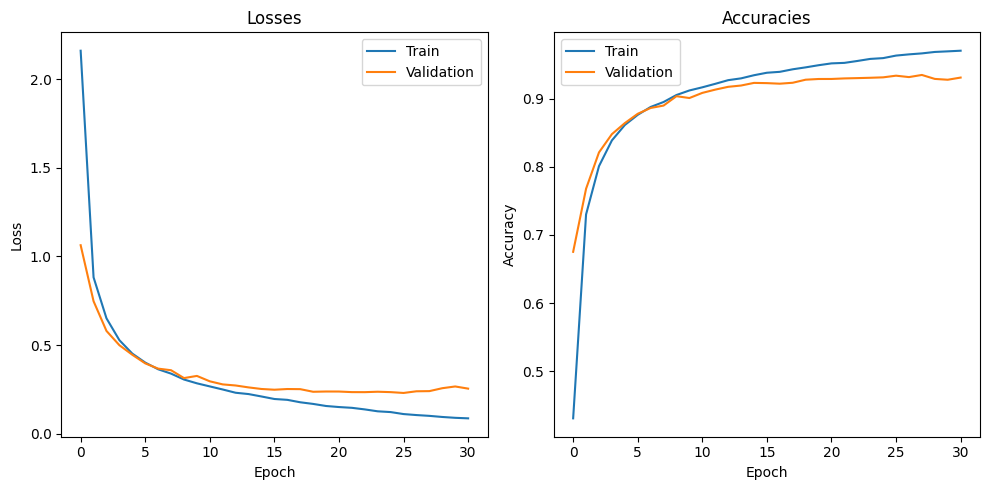

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].plot(history.history['loss'], label="Train")
axs[0].plot(history.history['val_loss'], label='Validation')
axs[0].set_title('Losses')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend()


axs[1].plot(history.history['accuracy'], label='Train')
axs[1].plot(history.history['val_accuracy'], label='Validation')
axs[1].set_title('Accuracies')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

plt.tight_layout()
plt.show()

In [9]:
# teszt adatok
test_data = pd.read_csv(os.path.join(preproccessed_test_directory_path, 'test_data.gz'), compression='gzip') # teszt adatok betoltese
test_list = []
test_data['processed_points'] = test_data['drawing'].apply(process_points) # teszt adatokhoz [(x,y,1)] tomb meghatarozasa
x_test = list(test_data['processed_points'])
y_test = test_data['word_id'].values
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', dtype='int32')

In [10]:
def model_predict(model, x=x_test):
  y_pred = model.predict(x)
  y_pred = np.argmax(y_pred, axis = 1)
  success_rate = np.sum(y_pred == y_test) / len(y_pred)
  return y_pred, success_rate

In [ ]:
y_pred, success_rate = model_predict(LSTM_Attention_model)

625/625 [==============================] - 4s 6ms/step


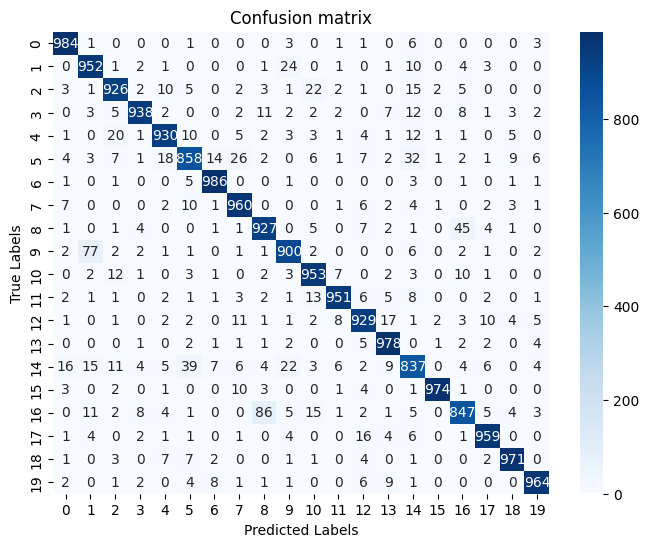

In [ ]:
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title("Confusion matrix")
plt.show()

In [ ]:
print('Success rate: ', success_rate)

Success rate:  0.9362


NameError: name 'y_pred' is not defined

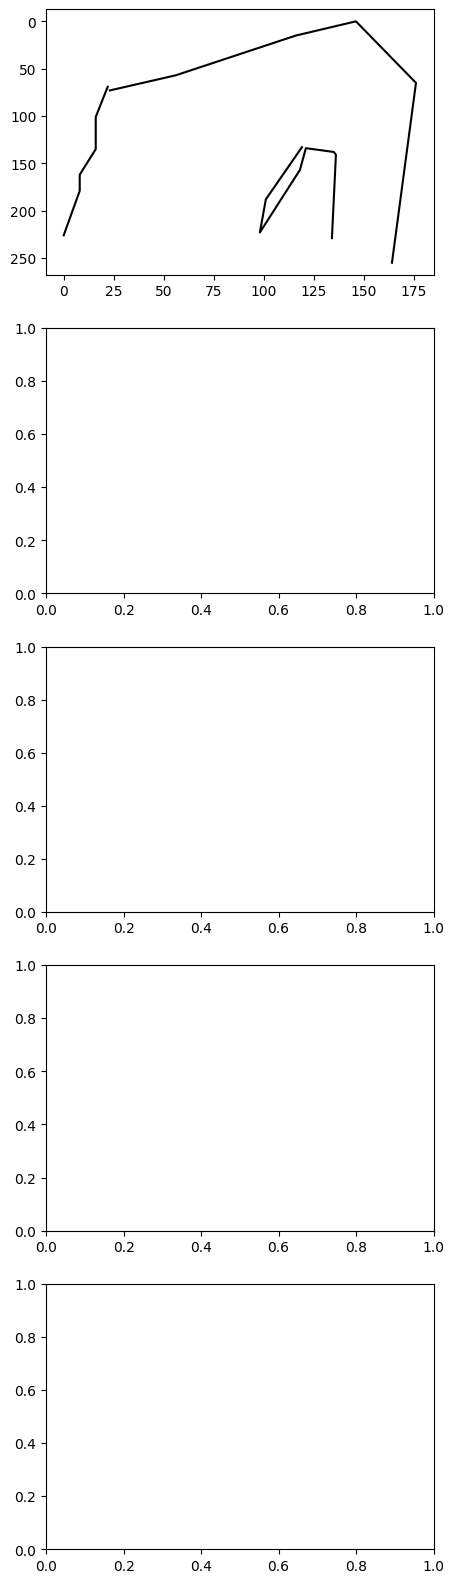

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(5, 20))
for drawing_ind in range(0,5):
  index = random.randint(1,len(test_data))
  for (x, y) in json.loads(test_data['drawing'][index]):
      axs[drawing_ind].plot(x, y, color='black')
  axs[drawing_ind].invert_yaxis()
  axs[drawing_ind].set_title('Predicted: '+str(category_name_by_id(dataframe,y_pred[index])+' | Real: '+str(category_name_by_id(dataframe,y_test[index]))))
  axs[drawing_ind].set_xticks([])
  axs[drawing_ind].set_yticks([])
plt.show()

sun
1/1 [==============================] - 0s 34ms/step


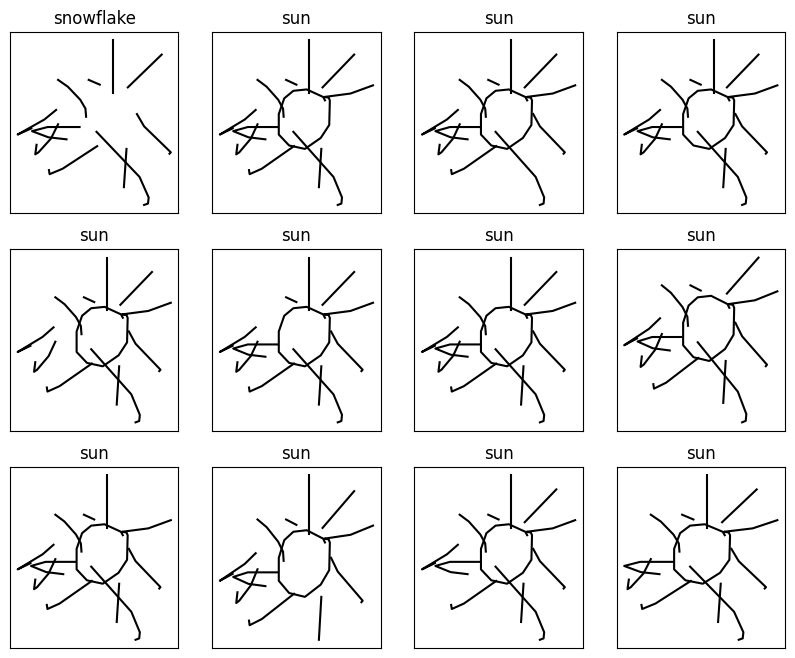

In [ ]:
chosen_index = 0
drawing = test_data['drawing'][chosen_index]
name = test_data['word'][chosen_index]
drawing_list = json.loads(drawing)
length = len(drawing_list)
cols = 4
rows = None
if math.ceil(length/cols) > 1:
  rows = math.ceil(length/cols)
else:
  rows = 2
fig, axs = plt.subplots(rows, cols, figsize=(10, 8))
c = 0
print(test_data['word'][chosen_index])
for i in range(0,rows):
  for k in range(0,cols):
    temp_drawing = drawing_list[:]
    if c >= length:
      break
    temp_drawing.pop(c)
    temp_proccessed_points = process_points(str(temp_drawing))
    for (x, y) in temp_drawing:
        axs[i,k].plot(x, y, color='black')
    axs[i,k].invert_yaxis()
    temp_proccessed_points = pad_sequences([temp_proccessed_points], maxlen=max_length, padding='post', dtype='int32')
    prediction, rate = model_predict(LSTM_Attention_model, temp_proccessed_points)
    name = category_name_by_id(dataframe, prediction[0])
    axs[i,k].set_title(name)
    axs[i,k].set_xticks([])
    axs[i,k].set_yticks([])
    c+=1

CNN innen

In [11]:
dimensions = (train_amount*num_classes,256,256)

In [12]:
def get_matrix_from_points(array, index, df=dataframe):
    points_with_ones = df['processed_points'][index]
    points = [(x, y) for x, y, _ in points_with_ones]
    x, y = zip(*points)
    for i in range(len(x) - 1):
        num_points = max(abs(x[i+1] - x[i]), abs(y[i+1] - y[i])) * 10
        points_on_line = zip(np.linspace(x[i], x[i+1], num=num_points).astype(int),
                             np.linspace(y[i], y[i+1], num=num_points).astype(int))
        for point in points_on_line:
            array[point] = 1

In [13]:
c=0
X = np.zeros(dimensions, np.uint8)
for i in tqdm(range(X.shape[0])):
  get_matrix_from_points(X[i,:,:],c)
  c+=1

100%|██████████| 200000/200000 [22:53<00:00, 145.59it/s]


In [14]:
y = dataframe['word_id'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [21]:
model = MobileNet(input_shape=(256, 256, 1), alpha=1, weights=None, classes=num_classes)
model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Model: "mobilenet_1.00_256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      288       
                                                                 
 conv1_bn (BatchNormalizati  (None, 128, 128, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 128, 128, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 128, 128, 32

In [22]:
checkpoint = ModelCheckpoint(os.path.join(models_directory_path,cnn_model_ckpt), monitor='val_loss', save_best_only=True, save_weights_only=False)
early_stopping = EarlyStopping(monitor='val_loss', patience=1)

In [23]:
model.fit(X_train, y_train, epochs=5, batch_size=200, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])

Epoch 1/5
800/800 [==============================] - 238s 289ms/step - loss: 0.3531 - accuracy: 0.8917 - val_loss: 0.6230 - val_accuracy: 0.8518
Epoch 2/5
800/800 [==============================] - 226s 282ms/step - loss: 0.1366 - accuracy: 0.9574 - val_loss: 0.2565 - val_accuracy: 0.9277
Epoch 3/5
800/800 [==============================] - 225s 282ms/step - loss: 0.1045 - accuracy: 0.9671 - val_loss: 0.2260 - val_accuracy: 0.9363
Epoch 4/5
800/800 [==============================] - 226s 282ms/step - loss: 0.0839 - accuracy: 0.9733 - val_loss: 0.2371 - val_accuracy: 0.9360


In [24]:
model.evaluate(X_val, y_val)

1250/1250 [==============================] - 14s 11ms/step - loss: 0.2371 - accuracy: 0.9360


[0.23714226484298706, 0.9360499978065491]

In [ ]:
model.load_weights(os.path.join(models_directory_path, cnn_model_ckpt))

In [25]:
test_data = pd.read_csv(os.path.join(preproccessed_test_directory_path, 'test_data.gz'), compression='gzip') # teszt adatok betoltese
test_list = []
test_data['processed_points'] = test_data['drawing'].apply(process_points) # teszt adatokhoz [(x,y,1)] tomb meghatarozasa
y_test = test_data['word_id'].values

In [26]:
c=0
Xt = np.zeros((len(test_data),256,256), np.uint8)
for i in tqdm(range(Xt.shape[0])):
  get_matrix_from_points(Xt[i,:,:],c,test_data)
  c+=1

100%|██████████| 20000/20000 [02:19<00:00, 143.10it/s]


In [27]:
y_pred, success_rate = model_predict(model,Xt)

625/625 [==============================] - 6s 9ms/step


In [28]:
success_rate

0.9391

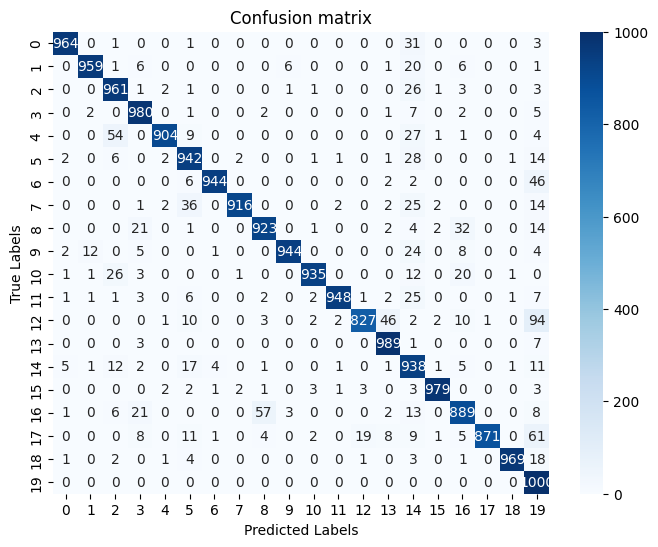

In [29]:
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title("Confusion matrix")
plt.show()

In [30]:
# ez jelenleg csak tesztelesre van
def load_and_convert_image(image_path):
    img = Image.open(image_path)
    img = img.rotate(90, expand=True)
    img_bw = img.convert('L')
    img_array = np.array(img_bw)
    img_binary = (img_array < 128).astype(int)
    return img_binary
image_path = 'house.png'
binary_image = load_and_convert_image(image_path)
binary_image = np.expand_dims(binary_image, axis=0)
pred = model.predict(binary_image)
print(category_name_by_id(dataframe,np.argmax(pred)))

FileNotFoundError: [Errno 2] No such file or directory: 'house.png'